In [2]:
import os
import numpy as np
import cv2

def load_images(folder, img_size=(64, 64)):
    images = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if filepath.endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load grayscale
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

folder_path = r"D:\ImageML"
data = load_images(folder_path)
print(f"Loaded data shape: {data.shape}")


Loaded data shape: (21196, 64, 64)


In [19]:
from sklearn.model_selection import train_test_split

# Split data into train (80%) and test (20%) sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Define image_shape based on your image dimensions
image_shape = (64, 64)  # Adjust the dimensions as needed

# Reshape data for input to models
X_train = X_train.reshape(X_train.shape[0], *image_shape)
X_test = X_test.reshape(X_test.shape[0], *image_shape)
print(X_train.shape)

(16956, 64, 64)


In [20]:
data_flattened = X_train.reshape(X_train.shape[0], -1)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator(latent_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='sigmoid')  # Output same shape as image data
    ])
    return model


In [22]:
def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    return model


In [23]:
def build_encoder(input_dim, latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(latent_dim, activation='linear')  # Latent representation
    ])
    return model


In [24]:
# Standard Adam optimizer
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Define generator, discriminator, and encoder
latent_dim = 10
image_dim = data_flattened.shape[1]

generator = build_generator(latent_dim, image_dim)
discriminator = build_discriminator(image_dim)
encoder = build_encoder(image_dim, latent_dim)

# Compile discriminator
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_d,
    metrics=['accuracy']
)

# Freeze the discriminator when training the generator
discriminator.trainable = False
z = tf.keras.Input(shape=(latent_dim,))
generated_data = generator(z)
valid = discriminator(generated_data)

# Define combined model
combined_model = tf.keras.Model(z, valid)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_g
)

# Training loop
epochs = 100
batch_size = 64

# Initialize lists to store metrics
d_losses = []
g_losses = []
d_accuracies = []

# Training loop
for epoch in range(epochs):
    # Train discriminator
    real_data = data_flattened[np.random.randint(0, data_flattened.shape[0], batch_size)]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    synthetic_data = generator.predict(noise)

    # Labels for real (1) and fake (0)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake data
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(synthetic_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Track discriminator accuracy
    d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])  # Average accuracy
    d_accuracies.append(d_acc)
    d_losses.append(d_loss[0])  # Loss value only

    # Train generator via the combined model
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined_model.train_on_batch(noise, real_labels)
    g_losses.append(g_loss)

    # Logging
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")


2/2 [==============================] - 0s 4ms/step
Epoch 0, D Loss: 2.0317, G Loss: 0.4235
2/2 [==============================] - 0s 12ms/step
Epoch 1, D Loss: 0.5363, G Loss: 1.6805
2/2 [==============================] - 0s 14ms/step
Epoch 2, D Loss: 0.3259, G Loss: 2.4199
2/2 [==============================] - 0s 2ms/step
Epoch 3, D Loss: 0.3625, G Loss: 2.0464
2/2 [==============================] - 0s 7ms/step
Epoch 4, D Loss: 0.2268, G Loss: 2.1693
2/2 [==============================] - 0s 12ms/step
Epoch 5, D Loss: 0.1414, G Loss: 2.4700
2/2 [==============================] - 0s 3ms/step
Epoch 6, D Loss: 0.1243, G Loss: 2.8799
2/2 [==============================] - 0s 4ms/step
Epoch 7, D Loss: 0.1204, G Loss: 2.9986
2/2 [==============================] - 0s 3ms/step
Epoch 8, D Loss: 0.0931, G Loss: 3.1655
2/2 [==============================] - 0s 3ms/step
Epoch 9, D Loss: 0.0572, G Loss: 3.4006
2/2 [==============================] - 0s 10ms/step
Epoch 10, D Loss: 0.0646, G Loss: 3

In [25]:
print(d_losses)
print("\n")
print(g_losses)

[2.0317259430885315, 0.5362599417567253, 0.3258778750896454, 0.36249273270368576, 0.22677075862884521, 0.14137305319309235, 0.12429219111800194, 0.12044128775596619, 0.0931282676756382, 0.05723300576210022, 0.06463310495018959, 0.0673608910292387, 0.05186003539711237, 0.03696145489811897, 0.04901237227022648, 0.03980660438537598, 0.024434423074126244, 0.02695818617939949, 0.028670646250247955, 0.03802393190562725, 0.05691056326031685, 0.02183509338647127, 0.02319542970508337, 0.02075336594134569, 0.012226702645421028, 0.015601211227476597, 0.009391833562403917, 0.009201550390571356, 0.009149892954155803, 0.010138920275494456, 0.009965170407667756, 0.016077588312327862, 0.014164171181619167, 0.010234577814117074, 0.013807489071041346, 0.014136476442217827, 0.00643614842556417, 0.009056108305230737, 0.006865372881293297, 0.007073680404573679, 0.0069944270653650165, 0.0059388692025095224, 0.005254076328128576, 0.00519875786267221, 0.005955019500106573, 0.002100279787555337, 0.008528893347

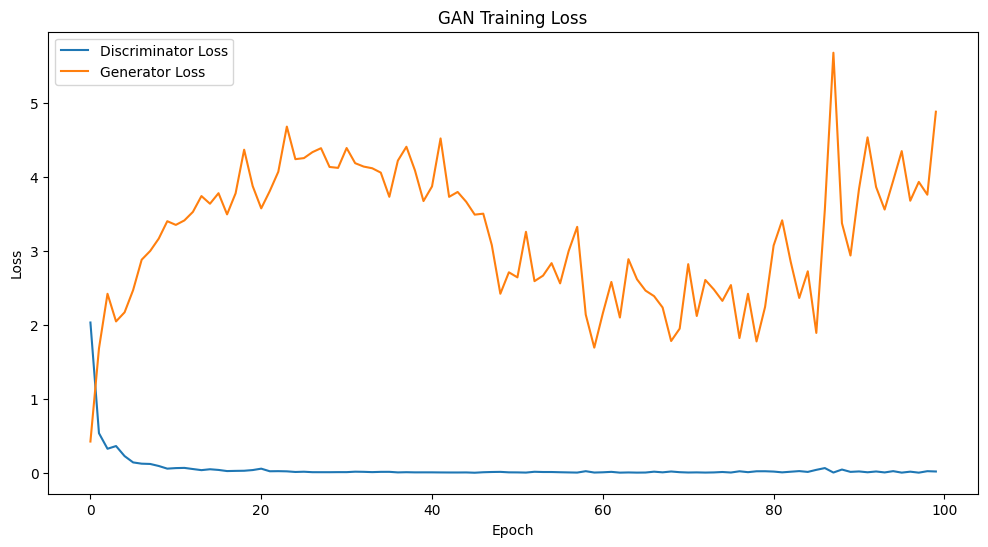

In [32]:
import matplotlib.pyplot as plt

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('D:\Mac\GAN Training Loss.png')
plt.show()

In [27]:
data_flattened2 = X_test.reshape(X_test.shape[0], -1)

In [28]:
latent_representations = encoder.predict(data_flattened2)


133/133 [==============================] - 0s 2ms/step


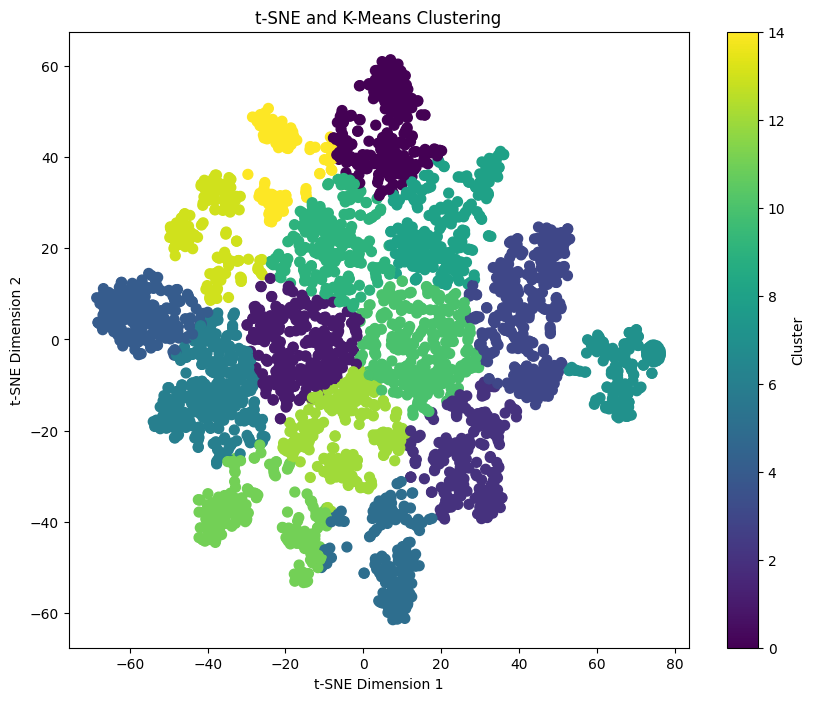

In [33]:
# Using t-SNE for visualization
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_representations)

# Cluster using KMeans in t-SNE space
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(tsne_results)

# Visualize the clustering
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("t-SNE and K-Means Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label='Cluster')
plt.savefig('D:\Mac\GAN clustering.png')
plt.show()

In [30]:
# Evaluate on test set
test_loss, test_acc = discriminator.evaluate(X_test.reshape(X_test.shape[0], -1), np.ones((X_test.shape[0], 1)))
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

133/133 [==============================] - 1s 4ms/step - loss: 0.0083 - accuracy: 0.9974
Test Loss: 0.0083, Test Acc: 0.9974


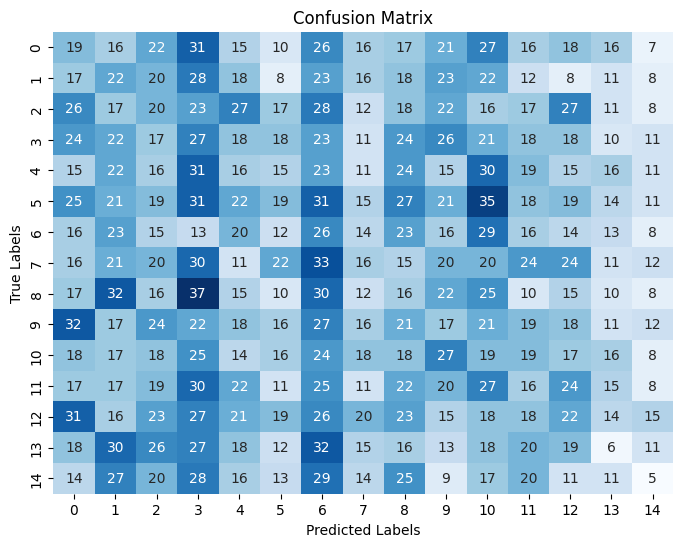

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate true labels for the test set (X_test) with the same size as clusters
true_labels = np.random.randint(0, 15, size=X_test.shape[0])

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, clusters)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(15), yticklabels=np.arange(15))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('D:\Mac\GAN confusion.png')
plt.show()